# Libraries

In [46]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from textblob import TextBlob
import datetime
import lightgbm as lgb
from sklearn.utils import resample
import optuna
from lightgbm import early_stopping, log_evaluation

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

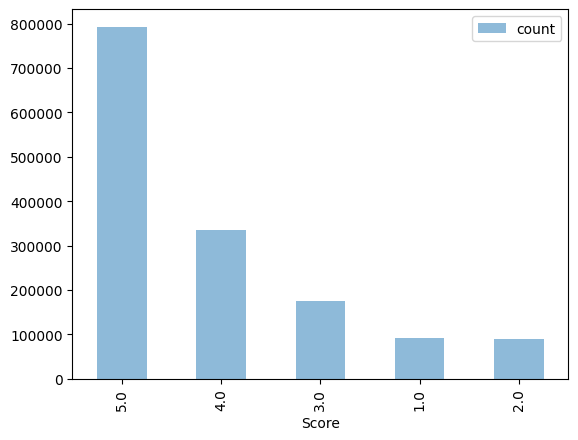


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [47]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

Methods:

In [48]:
def get_sentiment(text):
    """ to perform sentiment analysis on the review """
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity


# Adding Features

In [49]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Review length (number of words in review text)
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['ReviewLength'] = df['ReviewLength'].fillna(0)

    df['HelpfulnessLengthInteraction'] = df['Helpfulness'] * df['ReviewLength']
    df['HelpfulnessLengthInteraction'] = df['HelpfulnessLengthInteraction'].fillna(0)

    # Summary length (number of words in summary text)
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(str(x).split()))
    df['SummaryLength'] = df['SummaryLength'].fillna(0)

    # Time features
    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['Month'] = pd.to_datetime(df['Time'], unit='s').dt.month

    # Sentiment Scores
    df[['text_polarity', 'text_subjectivity']] = df['Text'].apply(lambda x: pd.Series(get_sentiment(x)))
    df[['summary_polarity', 'summary_subjectivity']] = df['Summary'].apply(lambda x: pd.Series(get_sentiment(x)))

    df['text_polarity'] = df['text_polarity'].fillna(0)
    df['text_subjectivity'] = df['text_subjectivity'].fillna(0)
    df['summary_polarity'] = df['summary_polarity'].fillna(0)
    df['summary_subjectivity'] = df['summary_subjectivity'].fillna(0)

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:

    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]
    # The training set where the Summary field is not null
    X_train.loc[:, 'Summary'] = X_train['Summary'].fillna('')
    # The training set where the Text field is not null
    X_train.loc[:, 'Text'] = X_train['Text'].fillna('')

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [51]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# X_train: A subset of the dataset’s features used for training the model.
# X_test: A subset of the dataset’s features used for testing the model.
# Y_train: The corresponding labels or target values for X_train.
# Y_test: The corresponding labels or target values for X_test.

# Feature Selection

In [54]:
features = ['Helpfulness', 'ReviewLength', 'HelpfulnessLengthInteraction', 'SummaryLength',
            'Year', 'Month', 'text_polarity', 'text_subjectivity', 'summary_polarity', 'summary_subjectivity']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [55]:
# Split the original training data into training and validation sets for Optuna
X_train_optuna, X_val_optuna, Y_train_optuna, Y_val_optuna = train_test_split(
    X_train_select, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

In [56]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'multiclass',
        'num_class': 5,  # Number of star rating classes
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'random_state': 42
    }
    
    # Create the LGBMClassifier with suggested parameters
    model = lgb.LGBMClassifier(**params)
    
    # Train with early stopping via callbacks
    model.fit(
        X_train_select, Y_train, 
        eval_set=[(X_test_select, Y_test)], 
        eval_metric="multi_logloss",
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
    )
    
    # Predict and calculate accuracy
    preds = model.predict(X_test_select)
    accuracy = accuracy_score(Y_test, preds)
    return accuracy

In [57]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best parameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params, objective='multiclass', num_class=5, random_state=42)
final_model.fit(X_train_select, Y_train)

[I 2024-10-28 12:33:41,311] A new study created in memory with name: no-name-93433ada-5d03-402a-96bb-896de97a609e
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.976978390539001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.976978390539001
[LightGBM] [Warning] bagging_fraction is set=0.7790314508553454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7790314508553454
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.976978390539001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.976978390539001
[LightGBM] [Warning] bagging_fraction is set=0.7790314508553454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7790314508553454
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_sampl

[I 2024-10-28 12:33:55,519] Trial 0 finished with value: 0.5759554689014801 and parameters: {'num_leaves': 34, 'learning_rate': 0.04455645425572091, 'feature_fraction': 0.976978390539001, 'bagging_fraction': 0.7790314508553454, 'bagging_freq': 1, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.5759554689014801.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7760601433928446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760601433928446
[LightGBM] [Warning] bagging_fraction is set=0.9540177972153381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540177972153381
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7760601433928446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7760601433928446
[LightGBM] [Warning] bagging_fraction is set=0.9540177972153381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9540177972153381
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_s

[I 2024-10-28 12:34:25,380] Trial 1 finished with value: 0.563602774845423 and parameters: {'num_leaves': 113, 'learning_rate': 0.013090620853858348, 'feature_fraction': 0.7760601433928446, 'bagging_fraction': 0.9540177972153381, 'bagging_freq': 5, 'min_data_in_leaf': 81}. Best is trial 0 with value: 0.5759554689014801.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7815410137205112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7815410137205112
[LightGBM] [Warning] bagging_fraction is set=0.7551241925790445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551241925790445
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7815410137205112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7815410137205112
[LightGBM] [Warning] bagging_fraction is set=0.7551241925790445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551241925790445
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_s

[I 2024-10-28 12:34:48,802] Trial 2 finished with value: 0.5821089256091518 and parameters: {'num_leaves': 85, 'learning_rate': 0.0805731305753479, 'feature_fraction': 0.7815410137205112, 'bagging_fraction': 0.7551241925790445, 'bagging_freq': 5, 'min_data_in_leaf': 97}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7258544590293206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7258544590293206
[LightGBM] [Warning] bagging_fraction is set=0.7350210649394974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7350210649394974
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7258544590293206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7258544590293206
[LightGBM] [Warning] bagging_fraction is set=0.7350210649394974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7350210649394974
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_s

[I 2024-10-28 12:35:07,179] Trial 3 finished with value: 0.5763971174354223 and parameters: {'num_leaves': 107, 'learning_rate': 0.028012019336857413, 'feature_fraction': 0.7258544590293206, 'bagging_fraction': 0.7350210649394974, 'bagging_freq': 1, 'min_data_in_leaf': 45}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7043689826680481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7043689826680481
[LightGBM] [Warning] bagging_fraction is set=0.8972537362568425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8972537362568425
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7043689826680481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7043689826680481
[LightGBM] [Warning] bagging_fraction is set=0.8972537362568425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8972537362568425
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_s

[I 2024-10-28 12:35:20,093] Trial 4 finished with value: 0.5635973888876921 and parameters: {'num_leaves': 36, 'learning_rate': 0.017335991733982415, 'feature_fraction': 0.7043689826680481, 'bagging_fraction': 0.8972537362568425, 'bagging_freq': 1, 'min_data_in_leaf': 48}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7172007779611668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7172007779611668
[LightGBM] [Warning] bagging_fraction is set=0.7126674671082074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126674671082074
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7172007779611668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7172007779611668
[LightGBM] [Warning] bagging_fraction is set=0.7126674671082074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7126674671082074
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_s

[I 2024-10-28 12:35:47,089] Trial 5 finished with value: 0.5669743843850313 and parameters: {'num_leaves': 119, 'learning_rate': 0.015488538891487668, 'feature_fraction': 0.7172007779611668, 'bagging_fraction': 0.7126674671082074, 'bagging_freq': 3, 'min_data_in_leaf': 81}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9882491569723721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9882491569723721
[LightGBM] [Warning] bagging_fraction is set=0.750987501482537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750987501482537
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9882491569723721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9882491569723721
[LightGBM] [Warning] bagging_fraction is set=0.750987501482537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750987501482537
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_sampl

[I 2024-10-28 12:36:13,109] Trial 6 finished with value: 0.5817857681452916 and parameters: {'num_leaves': 111, 'learning_rate': 0.07037123482148432, 'feature_fraction': 0.9882491569723721, 'bagging_fraction': 0.750987501482537, 'bagging_freq': 4, 'min_data_in_leaf': 57}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9080532207289892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9080532207289892
[LightGBM] [Warning] bagging_fraction is set=0.7345027928369394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7345027928369394
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9080532207289892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9080532207289892
[LightGBM] [Warning] bagging_fraction is set=0.7345027928369394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7345027928369394
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_s

[I 2024-10-28 12:36:26,842] Trial 7 finished with value: 0.5714501152594954 and parameters: {'num_leaves': 23, 'learning_rate': 0.033338608819917195, 'feature_fraction': 0.9080532207289892, 'bagging_fraction': 0.7345027928369394, 'bagging_freq': 3, 'min_data_in_leaf': 52}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9096224808285587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9096224808285587
[LightGBM] [Warning] bagging_fraction is set=0.7497922200607271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7497922200607271
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9096224808285587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9096224808285587
[LightGBM] [Warning] bagging_fraction is set=0.7497922200607271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7497922200607271
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_s

[I 2024-10-28 12:36:56,367] Trial 8 finished with value: 0.5790470086390762 and parameters: {'num_leaves': 145, 'learning_rate': 0.034684406792140465, 'feature_fraction': 0.9096224808285587, 'bagging_fraction': 0.7497922200607271, 'bagging_freq': 4, 'min_data_in_leaf': 81}. Best is trial 2 with value: 0.5821089256091518.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7696162919797442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696162919797442
[LightGBM] [Warning] bagging_fraction is set=0.7775790808568749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775790808568749
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7696162919797442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696162919797442
[LightGBM] [Warning] bagging_fraction is set=0.7775790808568749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775790808568749
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_s

[I 2024-10-28 12:37:21,698] Trial 9 finished with value: 0.582297434129737 and parameters: {'num_leaves': 107, 'learning_rate': 0.08490846650862624, 'feature_fraction': 0.7696162919797442, 'bagging_fraction': 0.7775790808568749, 'bagging_freq': 4, 'min_data_in_leaf': 66}. Best is trial 9 with value: 0.582297434129737.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8216309155488173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8216309155488173
[LightGBM] [Warning] bagging_fraction is set=0.8308536538853354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8308536538853354
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8216309155488173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8216309155488173
[LightGBM] [Warning] bagging_fraction is set=0.8308536538853354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8308536538853354
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_s

[I 2024-10-28 12:37:41,294] Trial 10 finished with value: 0.5815434000473965 and parameters: {'num_leaves': 62, 'learning_rate': 0.09698395665325647, 'feature_fraction': 0.8216309155488173, 'bagging_fraction': 0.8308536538853354, 'bagging_freq': 7, 'min_data_in_leaf': 22}. Best is trial 9 with value: 0.582297434129737.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7931914078889307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7931914078889307
[LightGBM] [Warning] bagging_fraction is set=0.8251782832956129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8251782832956129
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7931914078889307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7931914078889307
[LightGBM] [Warning] bagging_fraction is set=0.8251782832956129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8251782832956129
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_s

[I 2024-10-28 12:38:06,376] Trial 11 finished with value: 0.5812767951397118 and parameters: {'num_leaves': 80, 'learning_rate': 0.06478506526795455, 'feature_fraction': 0.7931914078889307, 'bagging_fraction': 0.8251782832956129, 'bagging_freq': 6, 'min_data_in_leaf': 99}. Best is trial 9 with value: 0.582297434129737.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7664943720204859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7664943720204859
[LightGBM] [Warning] bagging_fraction is set=0.8025891171923445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025891171923445
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7664943720204859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7664943720204859
[LightGBM] [Warning] bagging_fraction is set=0.8025891171923445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025891171923445
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_s

[I 2024-10-28 12:38:29,192] Trial 12 finished with value: 0.5821439343344034 and parameters: {'num_leaves': 84, 'learning_rate': 0.09305455555734686, 'feature_fraction': 0.7664943720204859, 'bagging_fraction': 0.8025891171923445, 'bagging_freq': 5, 'min_data_in_leaf': 99}. Best is trial 9 with value: 0.582297434129737.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8476619781460532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476619781460532
[LightGBM] [Warning] bagging_fraction is set=0.8821310699872031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8821310699872031
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8476619781460532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476619781460532
[LightGBM] [Warning] bagging_fraction is set=0.8821310699872031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8821310699872031
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_s

[I 2024-10-28 12:38:51,864] Trial 13 finished with value: 0.5796502359049486 and parameters: {'num_leaves': 63, 'learning_rate': 0.05180327932196994, 'feature_fraction': 0.8476619781460532, 'bagging_fraction': 0.8821310699872031, 'bagging_freq': 3, 'min_data_in_leaf': 68}. Best is trial 9 with value: 0.582297434129737.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.754312689158629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.754312689158629
[LightGBM] [Warning] bagging_fraction is set=0.8041534921454274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8041534921454274
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.754312689158629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.754312689158629
[LightGBM] [Warning] bagging_fraction is set=0.8041534921454274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8041534921454274
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_sampl

[I 2024-10-28 12:39:18,352] Trial 14 finished with value: 0.58309186289506 and parameters: {'num_leaves': 135, 'learning_rate': 0.0956177686461881, 'feature_fraction': 0.754312689158629, 'bagging_fraction': 0.8041534921454274, 'bagging_freq': 5, 'min_data_in_leaf': 66}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7395821484484542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7395821484484542
[LightGBM] [Warning] bagging_fraction is set=0.8673850732421707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8673850732421707
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7395821484484542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7395821484484542
[LightGBM] [Warning] bagging_fraction is set=0.8673850732421707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8673850732421707
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_s

[I 2024-10-28 12:39:49,082] Trial 15 finished with value: 0.5820496800741107 and parameters: {'num_leaves': 150, 'learning_rate': 0.0547856258894719, 'feature_fraction': 0.7395821484484542, 'bagging_fraction': 0.8673850732421707, 'bagging_freq': 7, 'min_data_in_leaf': 68}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8316602978734744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316602978734744
[LightGBM] [Warning] bagging_fraction is set=0.9257867574540838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9257867574540838
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8316602978734744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316602978734744
[LightGBM] [Warning] bagging_fraction is set=0.9257867574540838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9257867574540838
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_s

[I 2024-10-28 12:40:17,985] Trial 16 finished with value: 0.5767175819204171 and parameters: {'num_leaves': 129, 'learning_rate': 0.026057602600848943, 'feature_fraction': 0.8316602978734744, 'bagging_fraction': 0.9257867574540838, 'bagging_freq': 6, 'min_data_in_leaf': 68}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8740748154635333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8740748154635333
[LightGBM] [Warning] bagging_fraction is set=0.9919709260919555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9919709260919555
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8740748154635333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8740748154635333
[LightGBM] [Warning] bagging_fraction is set=0.9919709260919555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9919709260919555
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_s

[I 2024-10-28 12:40:47,998] Trial 17 finished with value: 0.5806627959583773 and parameters: {'num_leaves': 132, 'learning_rate': 0.042059833527301915, 'feature_fraction': 0.8740748154635333, 'bagging_fraction': 0.9919709260919555, 'bagging_freq': 2, 'min_data_in_leaf': 63}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7473122510407316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473122510407316
[LightGBM] [Warning] bagging_fraction is set=0.7946786131204238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7946786131204238
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7473122510407316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473122510407316
[LightGBM] [Warning] bagging_fraction is set=0.7946786131204238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7946786131204238
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_s

[I 2024-10-28 12:41:12,799] Trial 18 finished with value: 0.5728181485231704 and parameters: {'num_leaves': 96, 'learning_rate': 0.021310832305508415, 'feature_fraction': 0.7473122510407316, 'bagging_fraction': 0.7946786131204238, 'bagging_freq': 6, 'min_data_in_leaf': 38}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7959108519419777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959108519419777
[LightGBM] [Warning] bagging_fraction is set=0.842242582110012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.842242582110012
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7959108519419777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959108519419777
[LightGBM] [Warning] bagging_fraction is set=0.842242582110012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.842242582110012
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_sampl

[I 2024-10-28 12:41:40,680] Trial 19 finished with value: 0.5822651183833509 and parameters: {'num_leaves': 133, 'learning_rate': 0.06882330167282533, 'feature_fraction': 0.7959108519419777, 'bagging_fraction': 0.842242582110012, 'bagging_freq': 4, 'min_data_in_leaf': 74}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8788931011382168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8788931011382168
[LightGBM] [Warning] bagging_fraction is set=0.7811571970590294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811571970590294
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8788931011382168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8788931011382168
[LightGBM] [Warning] bagging_fraction is set=0.7811571970590294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811571970590294
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_s

[I 2024-10-28 12:42:02,688] Trial 20 finished with value: 0.5562724863735269 and parameters: {'num_leaves': 67, 'learning_rate': 0.010344410291439824, 'feature_fraction': 0.8788931011382168, 'bagging_fraction': 0.7811571970590294, 'bagging_freq': 4, 'min_data_in_leaf': 90}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8092779871357433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092779871357433
[LightGBM] [Warning] bagging_fraction is set=0.8507185841289663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507185841289663
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8092779871357433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8092779871357433
[LightGBM] [Warning] bagging_fraction is set=0.8507185841289663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507185841289663
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_s

[I 2024-10-28 12:42:30,170] Trial 21 finished with value: 0.5828225650085098 and parameters: {'num_leaves': 134, 'learning_rate': 0.07302344115410808, 'feature_fraction': 0.8092779871357433, 'bagging_fraction': 0.8507185841289663, 'bagging_freq': 4, 'min_data_in_leaf': 75}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8230058637055707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8230058637055707
[LightGBM] [Warning] bagging_fraction is set=0.8116506203133731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8116506203133731
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8230058637055707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8230058637055707
[LightGBM] [Warning] bagging_fraction is set=0.8116506203133731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8116506203133731
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_s

[I 2024-10-28 12:42:54,403] Trial 22 finished with value: 0.582356679664778 and parameters: {'num_leaves': 99, 'learning_rate': 0.08103810597187186, 'feature_fraction': 0.8230058637055707, 'bagging_fraction': 0.8116506203133731, 'bagging_freq': 5, 'min_data_in_leaf': 59}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8059058457553457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8059058457553457
[LightGBM] [Warning] bagging_fraction is set=0.8226899269753917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226899269753917
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8059058457553457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8059058457553457
[LightGBM] [Warning] bagging_fraction is set=0.8226899269753917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8226899269753917
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_s

[I 2024-10-28 12:43:23,280] Trial 23 finished with value: 0.5810694357670682 and parameters: {'num_leaves': 97, 'learning_rate': 0.05786517243485634, 'feature_fraction': 0.8059058457553457, 'bagging_fraction': 0.8226899269753917, 'bagging_freq': 5, 'min_data_in_leaf': 58}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8287019160474557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8287019160474557
[LightGBM] [Warning] bagging_fraction is set=0.8572736112068419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572736112068419
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8287019160474557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8287019160474557
[LightGBM] [Warning] bagging_fraction is set=0.8572736112068419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572736112068419
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_s

[I 2024-10-28 12:43:57,259] Trial 24 finished with value: 0.5824832496714566 and parameters: {'num_leaves': 138, 'learning_rate': 0.07739371039874354, 'feature_fraction': 0.8287019160474557, 'bagging_fraction': 0.8572736112068419, 'bagging_freq': 6, 'min_data_in_leaf': 76}. Best is trial 14 with value: 0.58309186289506.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8608806862181878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608806862181878
[LightGBM] [Warning] bagging_fraction is set=0.864151941837032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864151941837032
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8608806862181878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608806862181878
[LightGBM] [Warning] bagging_fraction is set=0.864151941837032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864151941837032
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_sampl

[I 2024-10-28 12:44:24,263] Trial 25 finished with value: 0.5833153801408967 and parameters: {'num_leaves': 140, 'learning_rate': 0.09964994195840352, 'feature_fraction': 0.8608806862181878, 'bagging_fraction': 0.864151941837032, 'bagging_freq': 6, 'min_data_in_leaf': 75}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.86756367988401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86756367988401
[LightGBM] [Warning] bagging_fraction is set=0.904058677352676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904058677352676
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.86756367988401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.86756367988401
[LightGBM] [Warning] bagging_fraction is set=0.904058677352676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.904058677352676
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 wi

[I 2024-10-28 12:44:52,319] Trial 26 finished with value: 0.5827767843677962 and parameters: {'num_leaves': 122, 'learning_rate': 0.0894881808286754, 'feature_fraction': 0.86756367988401, 'bagging_fraction': 0.904058677352676, 'bagging_freq': 7, 'min_data_in_leaf': 88}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9106768301464707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9106768301464707
[LightGBM] [Warning] bagging_fraction is set=0.9276486260485306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276486260485306
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9106768301464707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9106768301464707
[LightGBM] [Warning] bagging_fraction is set=0.9276486260485306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276486260485306
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_s

[I 2024-10-28 12:45:30,472] Trial 27 finished with value: 0.5814033651463903 and parameters: {'num_leaves': 143, 'learning_rate': 0.046488692137198154, 'feature_fraction': 0.9106768301464707, 'bagging_fraction': 0.9276486260485306, 'bagging_freq': 6, 'min_data_in_leaf': 74}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9450337778072609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450337778072609
[LightGBM] [Warning] bagging_fraction is set=0.852387928433535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.852387928433535
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9450337778072609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450337778072609
[LightGBM] [Warning] bagging_fraction is set=0.852387928433535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.852387928433535
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_sampl

[I 2024-10-28 12:45:57,380] Trial 28 finished with value: 0.5822785832776785 and parameters: {'num_leaves': 124, 'learning_rate': 0.09743840453186363, 'feature_fraction': 0.9450337778072609, 'bagging_fraction': 0.852387928433535, 'bagging_freq': 2, 'min_data_in_leaf': 88}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7532469410292707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7532469410292707
[LightGBM] [Warning] bagging_fraction is set=0.8944663869587208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944663869587208
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7532469410292707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7532469410292707
[LightGBM] [Warning] bagging_fraction is set=0.8944663869587208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944663869587208
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_s

[I 2024-10-28 12:46:28,173] Trial 29 finished with value: 0.5806924187258978 and parameters: {'num_leaves': 138, 'learning_rate': 0.04122317702230585, 'feature_fraction': 0.7532469410292707, 'bagging_fraction': 0.8944663869587208, 'bagging_freq': 5, 'min_data_in_leaf': 74}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9352701820687757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9352701820687757
[LightGBM] [Warning] bagging_fraction is set=0.8756161948648982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8756161948648982
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9352701820687757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9352701820687757
[LightGBM] [Warning] bagging_fraction is set=0.8756161948648982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8756161948648982
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_s

[I 2024-10-28 12:46:58,307] Trial 30 finished with value: 0.582356679664778 and parameters: {'num_leaves': 149, 'learning_rate': 0.06230611945751641, 'feature_fraction': 0.9352701820687757, 'bagging_fraction': 0.8756161948648982, 'bagging_freq': 3, 'min_data_in_leaf': 53}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.871011808022783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.871011808022783
[LightGBM] [Warning] bagging_fraction is set=0.9177635802350976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177635802350976
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.871011808022783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.871011808022783
[LightGBM] [Warning] bagging_fraction is set=0.9177635802350976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177635802350976
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_sampl

[I 2024-10-28 12:47:23,959] Trial 31 finished with value: 0.5828117930930478 and parameters: {'num_leaves': 121, 'learning_rate': 0.09730962971111143, 'feature_fraction': 0.871011808022783, 'bagging_fraction': 0.9177635802350976, 'bagging_freq': 7, 'min_data_in_leaf': 88}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8536099108867314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8536099108867314
[LightGBM] [Warning] bagging_fraction is set=0.945705635206051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.945705635206051
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8536099108867314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8536099108867314
[LightGBM] [Warning] bagging_fraction is set=0.945705635206051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.945705635206051
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_sampl

[I 2024-10-28 12:47:51,323] Trial 32 finished with value: 0.582405153284357 and parameters: {'num_leaves': 116, 'learning_rate': 0.07899285946634789, 'feature_fraction': 0.8536099108867314, 'bagging_fraction': 0.945705635206051, 'bagging_freq': 7, 'min_data_in_leaf': 91}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8887398918290115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8887398918290115
[LightGBM] [Warning] bagging_fraction is set=0.9882053828018625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9882053828018625
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8887398918290115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8887398918290115
[LightGBM] [Warning] bagging_fraction is set=0.9882053828018625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9882053828018625
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_s

[I 2024-10-28 12:48:20,508] Trial 33 finished with value: 0.5825694249951526 and parameters: {'num_leaves': 128, 'learning_rate': 0.07063895502847355, 'feature_fraction': 0.8887398918290115, 'bagging_fraction': 0.9882053828018625, 'bagging_freq': 6, 'min_data_in_leaf': 84}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8586413915128043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586413915128043
[LightGBM] [Warning] bagging_fraction is set=0.9618467009923648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9618467009923648
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8586413915128043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586413915128043
[LightGBM] [Warning] bagging_fraction is set=0.9618467009923648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9618467009923648
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_s

[I 2024-10-28 12:48:47,677] Trial 34 finished with value: 0.583005687571364 and parameters: {'num_leaves': 137, 'learning_rate': 0.09694690720024948, 'feature_fraction': 0.8586413915128043, 'bagging_fraction': 0.9618467009923648, 'bagging_freq': 7, 'min_data_in_leaf': 78}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8443281482127681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8443281482127681
[LightGBM] [Warning] bagging_fraction is set=0.9534607886186375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9534607886186375
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8443281482127681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8443281482127681
[LightGBM] [Warning] bagging_fraction is set=0.9534607886186375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9534607886186375
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_s

[I 2024-10-28 12:49:17,047] Trial 35 finished with value: 0.5826609862765797 and parameters: {'num_leaves': 139, 'learning_rate': 0.07348080028638017, 'feature_fraction': 0.8443281482127681, 'bagging_fraction': 0.9534607886186375, 'bagging_freq': 5, 'min_data_in_leaf': 81}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8080193628977285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080193628977285
[LightGBM] [Warning] bagging_fraction is set=0.7818115910607449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818115910607449
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8080193628977285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8080193628977285
[LightGBM] [Warning] bagging_fraction is set=0.7818115910607449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818115910607449
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_s

[I 2024-10-28 12:49:45,660] Trial 36 finished with value: 0.5825882758472112 and parameters: {'num_leaves': 136, 'learning_rate': 0.08453398208716993, 'feature_fraction': 0.8080193628977285, 'bagging_fraction': 0.7818115910607449, 'bagging_freq': 6, 'min_data_in_leaf': 77}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.781002014571044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.781002014571044
[LightGBM] [Warning] bagging_fraction is set=0.967936756770392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967936756770392
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.781002014571044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.781002014571044
[LightGBM] [Warning] bagging_fraction is set=0.967936756770392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967936756770392
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=2

[I 2024-10-28 12:50:06,432] Trial 37 finished with value: 0.5792812978003749 and parameters: {'num_leaves': 48, 'learning_rate': 0.06072361759924795, 'feature_fraction': 0.781002014571044, 'bagging_fraction': 0.967936756770392, 'bagging_freq': 7, 'min_data_in_leaf': 70}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.702527182249386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702527182249386
[LightGBM] [Warning] bagging_fraction is set=0.8411732711845155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411732711845155
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.702527182249386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702527182249386
[LightGBM] [Warning] bagging_fraction is set=0.8411732711845155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411732711845155
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_sampl

[I 2024-10-28 12:50:33,174] Trial 38 finished with value: 0.582437469030743 and parameters: {'num_leaves': 143, 'learning_rate': 0.09886474979428649, 'feature_fraction': 0.702527182249386, 'bagging_fraction': 0.8411732711845155, 'bagging_freq': 5, 'min_data_in_leaf': 63}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7306987638801206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7306987638801206
[LightGBM] [Warning] bagging_fraction is set=0.8625192144855224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8625192144855224
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7306987638801206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7306987638801206
[LightGBM] [Warning] bagging_fraction is set=0.8625192144855224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8625192144855224
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_s

[I 2024-10-28 12:51:01,298] Trial 39 finished with value: 0.5812310144989982 and parameters: {'num_leaves': 115, 'learning_rate': 0.050065784533388516, 'feature_fraction': 0.7306987638801206, 'bagging_fraction': 0.8625192144855224, 'bagging_freq': 6, 'min_data_in_leaf': 95}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8950939881403104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950939881403104
[LightGBM] [Warning] bagging_fraction is set=0.7099942453309029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7099942453309029
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8950939881403104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950939881403104
[LightGBM] [Warning] bagging_fraction is set=0.7099942453309029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7099942453309029
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_s

[I 2024-10-28 12:51:25,031] Trial 40 finished with value: 0.5821277764612103 and parameters: {'num_leaves': 105, 'learning_rate': 0.08517817322755232, 'feature_fraction': 0.8950939881403104, 'bagging_fraction': 0.7099942453309029, 'bagging_freq': 4, 'min_data_in_leaf': 84}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.859694735577222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.859694735577222
[LightGBM] [Warning] bagging_fraction is set=0.9232330224449743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232330224449743
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.859694735577222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.859694735577222
[LightGBM] [Warning] bagging_fraction is set=0.9232330224449743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232330224449743
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_sampl

[I 2024-10-28 12:51:51,023] Trial 41 finished with value: 0.5829949156559019 and parameters: {'num_leaves': 127, 'learning_rate': 0.09877926303809476, 'feature_fraction': 0.859694735577222, 'bagging_fraction': 0.9232330224449743, 'bagging_freq': 7, 'min_data_in_leaf': 77}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8613194928421471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8613194928421471
[LightGBM] [Warning] bagging_fraction is set=0.9722632038361162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722632038361162
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8613194928421471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8613194928421471
[LightGBM] [Warning] bagging_fraction is set=0.9722632038361162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722632038361162
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_s

[I 2024-10-28 12:52:18,202] Trial 42 finished with value: 0.5825478811642286 and parameters: {'num_leaves': 129, 'learning_rate': 0.07545940319400316, 'feature_fraction': 0.8613194928421471, 'bagging_fraction': 0.9722632038361162, 'bagging_freq': 7, 'min_data_in_leaf': 78}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.841545209444408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.841545209444408
[LightGBM] [Warning] bagging_fraction is set=0.9434392588517307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434392588517307
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.841545209444408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.841545209444408
[LightGBM] [Warning] bagging_fraction is set=0.9434392588517307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434392588517307
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_sampl

[I 2024-10-28 12:52:45,331] Trial 43 finished with value: 0.5832345907749316 and parameters: {'num_leaves': 144, 'learning_rate': 0.08729303823556048, 'feature_fraction': 0.841545209444408, 'bagging_fraction': 0.9434392588517307, 'bagging_freq': 7, 'min_data_in_leaf': 63}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8365236538674434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8365236538674434
[LightGBM] [Warning] bagging_fraction is set=0.9340726406956472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340726406956472
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8365236538674434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8365236538674434
[LightGBM] [Warning] bagging_fraction is set=0.9340726406956472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340726406956472
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_s

[I 2024-10-28 12:53:12,414] Trial 44 finished with value: 0.5830137665079604 and parameters: {'num_leaves': 144, 'learning_rate': 0.08796877364955187, 'feature_fraction': 0.8365236538674434, 'bagging_fraction': 0.9340726406956472, 'bagging_freq': 7, 'min_data_in_leaf': 48}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8410297679884605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410297679884605
[LightGBM] [Warning] bagging_fraction is set=0.9394104094126767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9394104094126767
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8410297679884605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410297679884605
[LightGBM] [Warning] bagging_fraction is set=0.9394104094126767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9394104094126767
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_s

[I 2024-10-28 12:53:39,458] Trial 45 finished with value: 0.5829356701208609 and parameters: {'num_leaves': 144, 'learning_rate': 0.08434728175088456, 'feature_fraction': 0.8410297679884605, 'bagging_fraction': 0.9394104094126767, 'bagging_freq': 7, 'min_data_in_leaf': 41}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8966973289413167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966973289413167
[LightGBM] [Warning] bagging_fraction is set=0.967489242919144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967489242919144
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8966973289413167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966973289413167
[LightGBM] [Warning] bagging_fraction is set=0.967489242919144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967489242919144
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_sampl

[I 2024-10-28 12:54:08,408] Trial 46 finished with value: 0.5824186181786846 and parameters: {'num_leaves': 150, 'learning_rate': 0.06689012862643896, 'feature_fraction': 0.8966973289413167, 'bagging_fraction': 0.967489242919144, 'bagging_freq': 6, 'min_data_in_leaf': 28}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9351182514170996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9351182514170996
[LightGBM] [Warning] bagging_fraction is set=0.9392753298482016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392753298482016
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9351182514170996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9351182514170996
[LightGBM] [Warning] bagging_fraction is set=0.9392753298482016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392753298482016
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_s

[I 2024-10-28 12:54:36,671] Trial 47 finished with value: 0.5829787577827089 and parameters: {'num_leaves': 143, 'learning_rate': 0.08894813301366156, 'feature_fraction': 0.9351182514170996, 'bagging_fraction': 0.9392753298482016, 'bagging_freq': 7, 'min_data_in_leaf': 48}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8373123018335378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8373123018335378
[LightGBM] [Warning] bagging_fraction is set=0.9084731771916095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9084731771916095
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8373123018335378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8373123018335378
[LightGBM] [Warning] bagging_fraction is set=0.9084731771916095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9084731771916095
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_s

[I 2024-10-28 12:55:05,851] Trial 48 finished with value: 0.5704564060581253 and parameters: {'num_leaves': 140, 'learning_rate': 0.016711244778337964, 'feature_fraction': 0.8373123018335378, 'bagging_fraction': 0.9084731771916095, 'bagging_freq': 6, 'min_data_in_leaf': 54}. Best is trial 25 with value: 0.5833153801408967.
/var/folders/f7/wlltk9qd3_z7dnq_l2mxs5jc0000gn/T/ipykernel_14828/2396154904.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9621093163105013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621093163105013
[LightGBM] [Warning] bagging_fraction is set=0.8930610795815405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8930610795815405
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9621093163105013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621093163105013
[LightGBM] [Warning] bagging_fraction is set=0.8930610795815405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8930610795815405
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_s

[I 2024-10-28 12:55:30,967] Trial 49 finished with value: 0.582399767326626 and parameters: {'num_leaves': 109, 'learning_rate': 0.08934690006405958, 'feature_fraction': 0.9621093163105013, 'bagging_fraction': 0.8930610795815405, 'bagging_freq': 7, 'min_data_in_leaf': 44}. Best is trial 25 with value: 0.5833153801408967.


Best parameters: {'num_leaves': 140, 'learning_rate': 0.09964994195840352, 'feature_fraction': 0.8608806862181878, 'bagging_fraction': 0.864151941837032, 'bagging_freq': 6, 'min_data_in_leaf': 75}
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8608806862181878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608806862181878
[LightGBM] [Warning] bagging_fraction is set=0.864151941837032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864151941837032
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8608806862181878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608806862181878
[LightGBM] [

LGBMClassifier(bagging_fraction=0.864151941837032, bagging_freq=6,
               feature_fraction=0.8608806862181878,
               learning_rate=0.09964994195840352, min_data_in_leaf=75,
               num_class=5, num_leaves=140, objective='multiclass',
               random_state=42)

# Model Evaluation

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8608806862181878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608806862181878
[LightGBM] [Warning] bagging_fraction is set=0.864151941837032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864151941837032
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
Final model accuracy on testing set: 0.5832857573733762


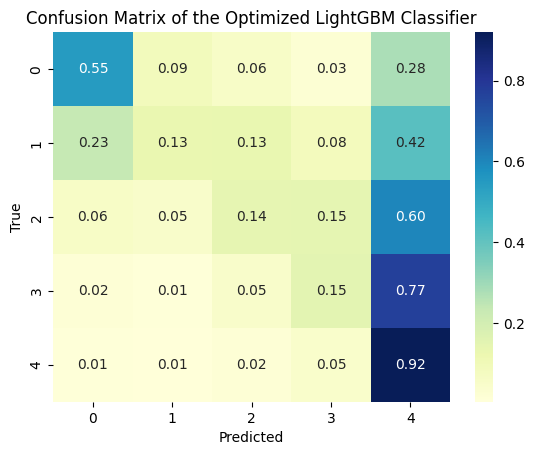

In [58]:
# Evaluate on the test set
Y_test_pred = final_model.predict(X_test_select)
accuracy = accuracy_score(Y_test, Y_test_pred)
print("Final model accuracy on testing set:", accuracy)


# Confusion Matrix
cm = confusion_matrix(Y_test, Y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Confusion Matrix of the Optimized LightGBM Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Create submission file

In [59]:
# Create the submission file
X_submission['Score'] = final_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8608806862181878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608806862181878
[LightGBM] [Warning] bagging_fraction is set=0.864151941837032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864151941837032
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
